
# Fibonacci Retrace → Extension Grid Search

This notebook runs a parameter sweep (grid search) over a Fibonacci retracement/extension strategy and reports the top-performing settings by **net R**, **profit factor**, and **max drawdown**.

**How to use:**

1. Paste your existing helper functions in the first code cell:
   - `load_day(date_str)` → returns a DataFrame with columns: `ts, open, high, low, close` (and ideally `volume`)
   - `ema(series, length)`, `rsi(series, length)`, `atr(df, length)`
   - `compute_fib_levels(df, direction='auto')` (temporary; see note about look-ahead below)

2. Update the `days` list with the sessions you want to backtest.

3. Run the notebook cells top-to-bottom.

> **Note on look-ahead:** `compute_fib_levels` that uses full-day high/low is *leaky*. For robust results, anchor the fib to the **last completed swing** (e.g., ZigZag) available at the time of entry.


In [8]:
# === Paste your helper functions below =======================================
# This cell sets up DuckDB httpfs (MinIO/S3) and defines: load_day, ema, rsi, atr, compute_fib_levels

import os, duckdb, pandas as pd, numpy as np

# Configure DuckDB httpfs from environment (.env)
S3_ENDPOINT = (os.getenv('S3_ENDPOINT_URL', '127.0.0.1:9100').replace('http://','').replace('https://',''))
S3_REGION = os.getenv('S3_REGION', 'us-east-1')
S3_USE_SSL = os.getenv('S3_USE_SSL', 'false')
S3_AK = os.getenv('S3_ACCESS_KEY_ID') or os.getenv('MINIO_ROOT_USER', 'minioadmin')
S3_SK = os.getenv('S3_SECRET_ACCESS_KEY') or os.getenv('MINIO_ROOT_PASSWORD', 'minioadmin')
BUCKET = os.getenv('MINIO_BUCKET', 'antman-lake')

con = duckdb.connect()
con.execute('INSTALL httpfs; LOAD httpfs;')
con.execute("SET s3_url_style='path';")
con.execute(f"SET s3_use_ssl='{S3_USE_SSL}';")
con.execute(f"SET s3_region='{S3_REGION}';")
con.execute(f"SET s3_endpoint='{S3_ENDPOINT}';")
con.execute("SET s3_access_key_id=$1;", [S3_AK])
con.execute("SET s3_secret_access_key=$1;", [S3_SK])
print('Configured DuckDB httpfs for MinIO at', S3_ENDPOINT, 'Bucket:', BUCKET)

# Load one trading day from MinIO via DuckDB httpfs

def load_day(dt_str: str, ticker: str = 'SPY') -> pd.DataFrame:
    path = f"s3://{BUCKET}/silver/symbol={ticker}/resolution=1min/dt={dt_str}/*.parquet"
    try:
        df = con.execute("SELECT * FROM read_parquet($1, filename=true)", [path]).df()
    except Exception as e:
        print('read_parquet failed:', e)
        return pd.DataFrame()
    # Normalize timestamp column
    ts_col = None
    for c in ['ts','utc_timestamp','timestamp','datetime']:
        if c in df.columns:
            ts_col = c; break
    if ts_col is None:
        return pd.DataFrame()
    df['ts'] = pd.to_datetime(df[ts_col], utc=True, errors='coerce')
    kept = [c for c in ['ts','open','high','low','close','volume'] if c in df.columns]
    df = df[kept].dropna(subset=['ts']).sort_values('ts').reset_index(drop=True)
    df['ts'] = df['ts'].dt.round('ms')
    return df

# TA helpers

def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def rsi(s: pd.Series, n: int = 14) -> pd.Series:
    d = s.diff()
    up = d.clip(lower=0)
    dn = -d.clip(upper=0)
    roll_up = up.ewm(alpha=1/n, adjust=False).mean()
    roll_dn = dn.ewm(alpha=1/n, adjust=False).mean()
    rs = np.where(roll_dn==0, np.nan, roll_up/roll_dn)
    return pd.Series(100 - (100/(1+rs)), index=s.index)

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    if not {'high','low','close'}.issubset(df.columns) or df.empty:
        return pd.Series(dtype='float64')
    prev_close = df['close'].shift(1)
    tr1 = (df['high'] - df['low']).abs()
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.ewm(alpha=1/n, adjust=False).mean()

# Fibonacci helpers
FIB_RATIOS = [0.0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0]
FIB_NAMES = ['0%', '23.6%', '38.2%', '50%', '61.8%', '78.6%', '100%']

def compute_fib_levels(df: pd.DataFrame, direction: str = 'auto'):
    if 'high' not in df.columns or 'low' not in df.columns or df.empty:
        return None
    idx_low = df['low'].idxmin()
    idx_high = df['high'].idxmax()
    lo = float(df.loc[idx_low, 'low'])
    hi = float(df.loc[idx_high, 'high'])
    ts_lo = df.loc[idx_low, 'ts'] if 'ts' in df.columns else None
    ts_hi = df.loc[idx_high, 'ts'] if 'ts' in df.columns else None

    if direction == 'auto':
        direction = 'up' if idx_low < idx_high else 'down'

    levels = []
    if direction == 'up':
        for r, name in zip(FIB_RATIOS, FIB_NAMES):
            lvl = lo + (hi - lo) * r
            levels.append((name, lvl))
    else:
        for r, name in zip(FIB_RATIOS, FIB_NAMES):
            lvl = hi - (hi - lo) * r
            levels.append((name, lvl))
    return {
        'direction': direction,
        'low': lo,
        'high': hi,
        'ts_low': ts_lo,
        'ts_high': ts_hi,
        'levels': levels,
    }


Configured DuckDB httpfs for MinIO at localhost:9100 Bucket: antman-lake


In [9]:
# === QUICK-TWEAKED SIM (wider window, looser filters, bidirectional) =========
def _simulate_one_quicktuned(day,
                             ema_fast=9, ema_slow=21, rsi_len=14,
                             rsi_long=48, rsi_short=48,            # looser
                             atr_len=14,
                             atr_mult_stop=0.5,
                             retr_low=0.382, retr_high=0.618,      # wider zone
                             ext_pref=('161','127'),
                             session_filter=("09:35","12:00","13:00","15:55")):  # wider window
    df = load_day(day)
    if df.empty:
        print(f"[smoke] {day}: no bars"); return pd.DataFrame()

    # indicators
    df['ema_fast'] = ema(df['close'], ema_fast)
    df['ema_slow'] = ema(df['close'], ema_slow)
    df['rsi']      = rsi(df['close'], rsi_len)
    df['atr']      = atr(df, atr_len)

    # session window
    if session_filter:
        def in_win(ts, wins):
            t = pd.to_datetime(ts).time()
            return any(pd.to_datetime(s).time() <= t <= pd.to_datetime(e).time()
                       for s,e in zip(wins[::2], wins[1::2]))
        df = df[df['ts'].apply(lambda x: in_win(x, session_filter))].reset_index(drop=True)
        if df.empty:
            print(f"[smoke] {day}: no bars in session window"); return pd.DataFrame()

    # daily fib context (still simple; we just don’t gate by its 'direction')
    fibc = compute_fib_levels(df, direction='auto')
    if not fibc:
        print(f"[smoke] {day}: could not compute fib"); return pd.DataFrame()
    lo, hi = float(fibc['low']), float(fibc['high'])
    rng = hi - lo
    Llo = lo + float(retr_low)  * rng
    Lhi = lo + float(retr_high) * rng
    Llo, Lhi = (min(Llo, Lhi), max(Llo, Lhi))

    # extension targets from same context (used at entry)
    ext127_up = hi + 0.272*rng; ext161_up = hi + 0.618*rng
    ext127_dn = lo - 0.272*rng; ext161_dn = lo - 0.618*rng

    # ENTRY RULES (bidirectional; no day-direction gate)
    in_zone  = (df['low'] <= Lhi) & (df['high'] >= Llo)
    trend_up = df['ema_fast'] > df['ema_slow']
    trend_dn = df['ema_fast'] < df['ema_slow']
    df['long_entry']  = in_zone & trend_up  & (df['rsi'] >= rsi_long)
    df['short_entry'] = in_zone & trend_dn  & (df['rsi'] <= (100 - rsi_short))

    trades, N = [], len(df)
    i, last_exit = 0, -1
    while i < N:
        if i <= last_exit: i += 1; continue
        row = df.iloc[i]
        side = 'LONG' if row.get('long_entry', False) else ('SHORT' if row.get('short_entry', False) else None)
        if not side: i += 1; continue

        entry_idx = i + 1
        if entry_idx >= N: break
        entry = float(df.iloc[entry_idx]['open'])
        atrv  = float(df.iloc[entry_idx]['atr'])

        # stop beyond opposite extreme with ATR buffer
        raw_stop = lo if side=='LONG' else hi
        stop = (raw_stop - atr_mult_stop*atrv) if side=='LONG' else (raw_stop + atr_mult_stop*atrv)
        R = abs(entry - stop)
        if not np.isfinite(R) or R <= 0: i += 1; continue

        tp1 = entry + R if side=='LONG' else entry - R
        # pick proper extensions for the side
        ext127 = ext127_up if side=='LONG' else ext127_dn
        ext161 = ext161_up if side=='LONG' else ext161_dn

        stop_lvl, filled_half = stop, False
        exit_idx, reason, px_exit = N-1, 'EOD', float(df.iloc[N-1]['close'])

        for j in range(entry_idx+1, N):
            h = float(df.iloc[j]['high']); l = float(df.iloc[j]['low'])
            # stop first
            if (side=='LONG' and l <= stop_lvl) or (side=='SHORT' and h >= stop_lvl):
                exit_idx, reason, px_exit = j, 'STOP', stop_lvl
                pnl1 = (0.5*R if filled_half else -0.5*R)
                pnl2 = -0.5*R
                break
            # partial at +1R then BE
            if not filled_half and ((side=='LONG' and h >= tp1) or (side=='SHORT' and l <= tp1)):
                filled_half = True; pnl1 = 0.5*R; stop_lvl = entry
            # extensions
            if filled_half:
                if (side=='LONG' and h >= ext161) or (side=='SHORT' and l <= ext161):
                    exit_idx, reason, px_exit = j, 'TP161', ext161
                    gain = (ext161 - entry) if side=='LONG' else (entry - ext161)
                    pnl2 = 0.5*gain; break
                if (side=='LONG' and h >= ext127) or (side=='SHORT' and l <= ext127):
                    exit_idx, reason, px_exit = j, 'TP127', ext127
                    gain = (ext127 - entry) if side=='LONG' else (entry - ext127)
                    pnl2 = 0.5*gain; break
        else:
            # EOD flatten
            if filled_half:
                pnl1 = 0.5*R
                pnl2 = 0.5*((df.iloc[N-1]['close'] - entry) if side=='LONG' else (entry - df.iloc[N-1]['close']))
            else:
                both = 0.5*((df.iloc[N-1]['close'] - entry) if side=='LONG' else (entry - df.iloc[N-1]['close']))
                pnl1 = pnl2 = both

        pnl_R = (pnl1 + pnl2) / R
        trades.append({'ts_in': df.iloc[entry_idx]['ts'], 'side': side,
                       'exit_ts': df.iloc[exit_idx]['ts'], 'reason': reason, 'pnl_R': pnl_R})
        last_exit = exit_idx; i = last_exit + 1

    return pd.DataFrame(trades)

# Tell the multi-day runner to use the tuned simulator:
_simulate_one = _simulate_one_quicktuned


In [17]:
# === FIB SMOKE TEST (follow fib dir) + MULTI-DAY RUNNER ======================
import os, pandas as pd, numpy as np, math
from datetime import date, timedelta

# ---------- your existing single-day simulator (unchanged) ----------
def _simulate_one(day,
                  ema_fast=9, ema_slow=21, rsi_len=14,
                  rsi_long=45, rsi_short=55,
                  atr_len=14, atr_mult_stop=0.25,
                  retr_low=0.382, retr_high=0.786,
                  zone_pad_frac=0.02,
                  allow_slope_or=True,
                  ext_pref=('161','127'),
                  session_filter=("09:35","15:55")):
    df = load_day(day)
    if df.empty:
        print(f"[smoke] {day}: no bars"); return pd.DataFrame()

    # indicators
    df['ema_fast'] = ema(df['close'], ema_fast)
    df['ema_slow'] = ema(df['close'], ema_slow)
    df['rsi']      = rsi(df['close'], rsi_len)
    df['atr']      = atr(df, atr_len)

    # session filter
    if session_filter:
        def in_win(ts, wins):
            t = pd.to_datetime(ts).time()
            return any(pd.to_datetime(s).time() <= t <= pd.to_datetime(e).time()
                       for s,e in zip(wins[::2], wins[1::2]))
        df = df[df['ts'].apply(lambda x: in_win(x, session_filter))].reset_index(drop=True)
        if df.empty:
            print(f"[smoke] {day}: no bars in session window"); return pd.DataFrame()

    # fib context → decides direction
    fibc = compute_fib_levels(df, direction='auto')
    if not fibc:
        print(f"[smoke] {day}: could not compute fib"); return pd.DataFrame()
    lo, hi, direction = fibc['low'], fibc['high'], fibc['direction']
    rng = hi - lo

    # retrace band + padding
    Llo = lo + float(retr_low)  * rng
    Lhi = lo + float(retr_high) * rng
    lower, upper = min(Llo, Lhi), max(Llo, Lhi)
    pad = float(zone_pad_frac) * abs(rng)
    lower_exp, upper_exp = lower - pad, upper + pad

    # extensions
    ext_up127  = hi + 0.272*rng
    ext_up161  = hi + 0.618*rng
    ext_dn127  = lo - 0.272*rng
    ext_dn161  = lo - 0.618*rng

    # trend (softer)
    fast_slope = df['ema_fast'] - df['ema_fast'].shift(3)
    if allow_slope_or:
        trend_up = (df['ema_fast'] > df['ema_slow']) | (fast_slope > 0)
        trend_dn = (df['ema_fast'] < df['ema_slow']) | (fast_slope < 0)
    else:
        trend_up = df['ema_fast'] > df['ema_slow']
        trend_dn = df['ema_fast'] < df['ema_slow']

    # momentum (looser)
    long_mom_ok  = df['rsi'] >= rsi_long
    short_mom_ok = df['rsi'] <= rsi_short

    # in-zone touch with padding
    in_zone = (df['low'] <= upper_exp) & (df['high'] >= lower_exp)

    # FOLLOW FIB DIRECTION ONLY
    if direction == 'up':
        df['long_entry']  = in_zone & trend_up  & long_mom_ok
        df['short_entry'] = False
    else:  # direction == 'down'
        df['short_entry'] = in_zone & trend_dn & short_mom_ok
        df['long_entry']  = False

    trades, N = [], len(df)
    i, last_exit = 0, -1

    while i < N:
        if i <= last_exit:
            i += 1; continue

        row = df.iloc[i]
        side = 'LONG' if row.get('long_entry', False) else ('SHORT' if row.get('short_entry', False) else None)
        if not side:
            i += 1; continue

        entry_idx = i + 1
        if entry_idx >= N: break

        entry = float(df.iloc[entry_idx]['open'])
        atrv  = float(df.iloc[entry_idx]['atr']) if np.isfinite(float(df.iloc[entry_idx]['atr'])) else 0.0
        raw_stop = float(lo) if side=='LONG' else float(hi)
        stop = raw_stop - atr_mult_stop*atrv if side=='LONG' else raw_stop + atr_mult_stop*atrv
        R = abs(entry - stop)
        if not np.isfinite(R) or R <= 0:
            i += 1; continue

        tp1 = entry + R if side=='LONG' else entry - R
        # choose proper extensions by side
        if side == 'LONG':
            ext1 = ext_up161 if ext_pref[0]=='161' else ext_up127
            ext2 = ext_up127 if ext_pref[1]=='127' else ext_up161
        else:
            ext1 = ext_dn161 if ext_pref[0]=='161' else ext_dn127
            ext2 = ext_dn127 if ext_pref[1]=='127' else ext_dn161

        stop_lvl, filled_half = stop, False
        exit_idx, reason, px_exit = N-1, 'EOD', float(df.iloc[N-1]['close'])

        for j in range(entry_idx+1, N):
            h = float(df.iloc[j]['high']); l = float(df.iloc[j]['low'])

            # stop first
            if (side=='LONG' and l <= stop_lvl) or (side=='SHORT' and h >= stop_lvl):
                exit_idx, reason, px_exit = j, ('STOP_BE' if (filled_half and stop_lvl==entry) else 'STOP'), stop_lvl
                if filled_half:
                    pnl1 = 0.5*R; pnl2 = -0.5*R
                else:
                    pnl1 = pnl2 = -0.5*R
                break

            # partial at +1R → move stop to BE
            if not filled_half and ((side=='LONG' and h >= tp1) or (side=='SHORT' and l <= tp1)):
                filled_half = True; pnl1 = 0.5*R; stop_lvl = entry

            # extension exits
            if filled_half:
                hit1 = (side=='LONG' and h >= ext1) or (side=='SHORT' and l <= ext1)
                hit2 = (side=='LONG' and h >= ext2) or (side=='SHORT' and l <= ext2)
                if hit1 or hit2:
                    target = ext1 if hit1 else ext2
                    reason = f"TP{('161' if (target in (ext_up161, ext_dn161)) else '127')}"
                    exit_idx, px_exit = j, target
                    gain = (target - entry) if side=='LONG' else (entry - target)
                    pnl2 = 0.5*gain
                    break
        else:
            # end of day
            if filled_half:
                pnl1 = 0.5*R
                pnl2 = 0.5*((df.iloc[N-1]['close'] - entry) if side=='LONG' else (entry - df.iloc[N-1]['close']))
            else:
                both = 0.5*((df.iloc[N-1]['close'] - entry) if side=='LONG' else (entry - df.iloc[N-1]['close']))
                pnl1 = pnl2 = both

        pnl_R = (pnl1 + pnl2) / R
        trades.append({
            'ts_in': df.iloc[entry_idx]['ts'],
            'side': side,
            'exit_ts': df.iloc[exit_idx]['ts'],
            'reason': reason,
            'pnl_R': pnl_R
        })
        last_exit = exit_idx
        i = last_exit + 1

    return pd.DataFrame(trades)

def _summ(df):
    if df.empty: return "[smoke] no trades"
    wins = (df['pnl_R']>0).sum()
    netR = df['pnl_R'].sum()
    grossW = df.loc[df['pnl_R']>0,'pnl_R'].sum()
    grossL = -df.loc[df['pnl_R']<=0,'pnl_R'].sum()
    pf = (grossW/grossL) if grossL>0 else float('inf')
    dd = (df['pnl_R'].cumsum() - df['pnl_R'].cumsum().cummax()).min()
    return f"{len(df)} trades | netR={netR:.2f} | PF={pf:.2f} | maxDD={dd:.2f} | win%={( (df['pnl_R']>0).mean()*100 if len(df) else 0):.0f}%"

# ---------- NEW: multi-day helper ----------
def fib_smoke_multi(days):
    """Run _simulate_one across a list of ISO dates; print per-day + totals."""
    all_trades = []
    for d in days:
        t = _simulate_one(d)
        print("[smoke]", d, "→", _summ(t))
        if not t.empty:
            df_d = t.copy()
            df_d["day"] = d
            all_trades.append(df_d)

    if not all_trades:
        print("\n[smoke] No trades across selected days.")
        return pd.DataFrame()

    df_all = pd.concat(all_trades, ignore_index=True)
    # combined summary
    wins = (df_all['pnl_R']>0).sum()
    netR = df_all['pnl_R'].sum()
    grossW = df_all.loc[df_all['pnl_R']>0,'pnl_R'].sum()
    grossL = -df_all.loc[df_all['pnl_R']<=0,'pnl_R'].sum()
    pf = (grossW/grossL) if grossL>0 else float('inf')
    eq = df_all['pnl_R'].cumsum()
    maxDD = (eq - eq.cummax()).min()
    print(f"\n[total] {len(days)} days | trades={len(df_all)} | netR={netR:.2f} | PF={pf:.2f} | maxDD={maxDD:.2f} | win%={(wins/len(df_all))*100:.0f}%")
    return df_all

# ---------- convenience: date range builder ----------
def date_range(start, end):  # inclusive, ISO strings "YYYY-MM-DD"
    s = date.fromisoformat(start); e = date.fromisoformat(end)
    return [(s + timedelta(days=i)).isoformat() for i in range((e - s).days + 1)]

# ---------- EXAMPLES ----------
# Single day:
_ = _simulate_one("2025-03-11"); print("[smoke]", "2025-03-11", "→", _summ(_))

# Multi-day (explicit list):
days = ["2025-03-10","2025-03-11","2025-03-12"]
# df_multi = fib_smoke_multi(days)

# Multi-day (date range):
days = date_range("2025-03-03","2025-04-14")
df_multi = fib_smoke_multi(days)


[smoke] 2025-03-11 → 1 trades | netR=0.98 | PF=inf | maxDD=0.00 | win%=100%
[smoke] 2025-03-03 → 1 trades | netR=0.13 | PF=inf | maxDD=0.00 | win%=100%
[smoke] 2025-03-04 → 1 trades | netR=1.54 | PF=inf | maxDD=0.00 | win%=100%
[smoke] 2025-03-05 → 1 trades | netR=-0.27 | PF=0.00 | maxDD=0.00 | win%=0%
[smoke] 2025-03-06 → 1 trades | netR=0.82 | PF=inf | maxDD=0.00 | win%=100%
[smoke] 2025-03-07 → 1 trades | netR=0.11 | PF=inf | maxDD=0.00 | win%=100%
read_parquet failed: IO Error: No files found that match the pattern "s3://antman-lake/silver/symbol=SPY/resolution=1min/dt=2025-03-08/*.parquet"
[smoke] 2025-03-08: no bars
[smoke] 2025-03-08 → [smoke] no trades
read_parquet failed: IO Error: No files found that match the pattern "s3://antman-lake/silver/symbol=SPY/resolution=1min/dt=2025-03-09/*.parquet"
[smoke] 2025-03-09: no bars
[smoke] 2025-03-09 → [smoke] no trades
[smoke] 2025-03-10 → 1 trades | netR=-0.25 | PF=0.00 | maxDD=0.00 | win%=0%
[smoke] 2025-03-11 → 1 trades | netR=0.98 

In [ ]:
# === FIB SMOKE TEST (follow fib dir) + MULTI-DAY RUNNER ======================
import os, pandas as pd, numpy as np, math
from datetime import date, timedelta

# ---------- your existing single-day simulator (ROLLING FIB ENABLED) ----------
def _simulate_one(day,
                  # indicators
                  ema_fast=9, ema_slow=21, rsi_len=14,
                  # filters (kept loose)
                  rsi_long=45, rsi_short=55, allow_slope_or=True,
                  # risk/targets
                  atr_len=14, atr_mult_stop=0.25,
                  retr_low=0.382, retr_high=0.786,
                  zone_pad_frac=0.02,
                  ext_pref=('161','127'),
                  # rolling fib (ATR ZigZag)
                  zz_atr_mult=1.5,              # reversal threshold = zz_atr_mult * ATR
                  # session
                  session_filter=("09:35","15:55")):

    df = load_day(day)
    if df.empty:
        print(f"[smoke] {day}: no bars"); return pd.DataFrame()

    # indicators
    df['ema_fast'] = ema(df['close'], ema_fast)
    df['ema_slow'] = ema(df['close'], ema_slow)
    df['rsi']      = rsi(df['close'], rsi_len)
    df['atr']      = atr(df, atr_len)

    # session filter
    if session_filter:
        def in_win(ts, wins):
            t = pd.to_datetime(ts).time()
            return any(pd.to_datetime(s).time() <= t <= pd.to_datetime(e).time()
                       for s,e in zip(wins[::2], wins[1::2]))
        df = df[df['ts'].apply(lambda x: in_win(x, session_filter))].reset_index(drop=True)
        if df.empty:
            print(f"[smoke] {day}: no bars in session window"); return pd.DataFrame()

    # ===== Rolling fib via ATR ZigZag (bar-by-bar impulse) ===================
    atr_series = df['atr'].fillna(method='bfill').fillna(method='ffill')
    if atr_series.isna().all():
        print(f"[smoke] {day}: ATR NaN"); return pd.DataFrame()

    piv_px = float(df.iloc[0]['close'])
    dirn   = None               # 'up' or 'down'
    imp_lo = piv_px             # current impulse low
    imp_hi = piv_px             # current impulse high
    last_ext = piv_px           # last extreme in dirn

    cur_dir, lo_arr, hi_arr = [], [], []

    for i in range(len(df)):
        c   = float(df.iloc[i]['close'])
        atr_val = float(atr_series.iloc[i]) if np.isfinite(atr_series.iloc[i]) else 0.0
        thr = float(zz_atr_mult) * atr_val

        if dirn is None:
            if c >= piv_px + thr:
                dirn, imp_lo, imp_hi, last_ext = 'up', piv_px, c, c
            elif c <= piv_px - thr:
                dirn, imp_hi, imp_lo, last_ext = 'down', piv_px, c, c
            cur_dir.append(dirn)
            lo_arr.append(imp_lo)
            hi_arr.append(imp_hi)
            continue

        if dirn == 'up':
            if c > last_ext:
                last_ext = c; imp_hi = c
            elif (last_ext - c) >= thr:
                dirn = 'down'; piv_px = c; last_ext = c
                imp_lo = c
        else:  # dirn == 'down'
            if c < last_ext:
                last_ext = c; imp_lo = c
            elif (c - last_ext) >= thr:
                dirn = 'up'; piv_px = c; last_ext = c
                imp_hi = c

        cur_dir.append(dirn)
        lo_arr.append(imp_lo)
        hi_arr.append(imp_hi)
            continue

        if dirn == 'up':
            if c > last_ext:
                last_ext = c; imp_hi = c
            elif (last_ext - c) >= thr:
                # confirm reversal to down
                dirn = 'down'; piv_px = c; last_ext = c
                imp_lo = c  # new low starts here
                # imp_hi stays as the swing high of the finished impulse
        else:  # dirn == 'down'
            if c < last_ext:
                last_ext = c; imp_lo = c
            elif (c - last_ext) >= thr:
                # confirm reversal to up
                dirn = 'up'; piv_px = c; last_ext = c
                imp_hi = c  # new high starts here
                # imp_lo stays as the swing low of the finished impulse

        cur_dir.append(dirn)
        lo_arr.append(imp_lo)
        hi_arr.append(imp_hi)

    sdir = pd.Series(cur_dir, index=df.index)
    slo  = pd.Series(lo_arr,  index=df.index).astype(float)
    shi  = pd.Series(hi_arr,  index=df.index).astype(float)

    if sdir.isna().all():
        return pd.DataFrame()

    # ----- rolling fib levels per bar
    rng = (shi - slo).replace(0, np.nan)
    Llo = slo + float(retr_low)  * rng
    Lhi = slo + float(retr_high) * rng
    lower = pd.concat([Llo, Lhi], axis=1).min(axis=1)
    upper = pd.concat([Llo, Lhi], axis=1).max(axis=1)
    pad   = abs(rng) * float(zone_pad_frac)
    lower_exp = lower - pad
    upper_exp = upper + pad

    # extension targets per bar
    ext_up127 = shi + 0.272 * rng
    ext_up161 = shi + 0.618 * rng
    ext_dn127 = slo - 0.272 * rng
    ext_dn161 = slo - 0.618 * rng

    # ===== Filters ============================================================
    fast_slope = df['ema_fast'] - df['ema_fast'].shift(3)
    if allow_slope_or:
        trend_up = (df['ema_fast'] > df['ema_slow']) | (fast_slope > 0)
        trend_dn = (df['ema_fast'] < df['ema_slow']) | (fast_slope < 0)
    else:
        trend_up = (df['ema_fast'] > df['ema_slow'])
        trend_dn = (df['ema_fast'] < df['ema_slow'])

    long_mom_ok  = df['rsi'] >= rsi_long
    short_mom_ok = df['rsi'] <= rsi_short

    # fresh touch logic (leave -> reenter zone)
    in_zone = (df['low'] <= upper_exp) & (df['high'] >= lower_exp)
    fresh_touch = in_zone & (~in_zone.shift(1).fillna(False))

    # direction-following entries, now per-impulse
    df['long_entry']  = (sdir == 'up')   & fresh_touch & trend_up  & long_mom_ok
    df['short_entry'] = (sdir == 'down') & fresh_touch & trend_dn & short_mom_ok

    # ===== Trade simulation (same management) =================================
    trades, N = [], len(df)
    i, last_exit = 0, -1

    while i < N:
        if i <= last_exit:
            i += 1; continue

        row = df.iloc[i]
        side = 'LONG' if bool(row.get('long_entry', False)) else ('SHORT' if bool(row.get('short_entry', False)) else None)
        if not side:
            i += 1; continue

        entry_idx = i + 1
        if entry_idx >= N: break

        # snapshot at entry time (no lookahead)
        e_ts   = df.iloc[entry_idx]['ts']
        e_open = float(df.iloc[entry_idx]['open'])
        atrv   = float(df.iloc[entry_idx]['atr']) if np.isfinite(float(df.iloc[entry_idx]['atr'])) else 0.0

        slo_e  = float(slo.iloc[entry_idx]);  shi_e = float(shi.iloc[entry_idx])
        if not (np.isfinite(slo_e) and np.isfinite(shi_e)) or shi_e == slo_e:
            i += 1; continue

        # stop at current impulse extreme ± ATR buffer
        if side == 'LONG':
            raw_stop = slo_e
            stop = raw_stop - atr_mult_stop * atrv
            ext1 = float(ext_up161.iloc[entry_idx] if ext_pref[0]=='161' else ext_up127.iloc[entry_idx])
            ext2 = float(ext_up127.iloc[entry_idx] if ext_pref[1]=='127' else ext_up161.iloc[entry_idx])
        else:
            raw_stop = shi_e
            stop = raw_stop + atr_mult_stop * atrv
            ext1 = float(ext_dn161.iloc[entry_idx] if ext_pref[0]=='161' else ext_dn127.iloc[entry_idx])
            ext2 = float(ext_dn127.iloc[entry_idx] if ext_pref[1]=='127' else ext_dn161.iloc[entry_idx])

        R = abs(e_open - stop)
        if not np.isfinite(R) or R <= 0:
            i += 1; continue

        tp1 = e_open + R if side=='LONG' else e_open - R
        stop_lvl, filled_half = stop, False
        exit_idx, reason, px_exit = N-1, 'EOD', float(df.iloc[N-1]['close'])

        # walk forward bar-by-bar
        for j in range(entry_idx + 1, N):
            h = float(df.iloc[j]['high']); l = float(df.iloc[j]['low'])

            # stop first
            if (side=='LONG' and l <= stop_lvl) or (side=='SHORT' and h >= stop_lvl):
                exit_idx, reason, px_exit = j, ('STOP_BE' if (filled_half and stop_lvl==e_open) else 'STOP'), stop_lvl
                if filled_half:
                    pnl1 = 0.5*R; pnl2 = -0.5*R
                else:
                    pnl1 = pnl2 = -0.5*R
                break

            # partial at +1R → BE
            if not filled_half and ((side=='LONG' and h >= tp1) or (side=='SHORT' and l <= tp1)):
                filled_half = True; pnl1 = 0.5*R; stop_lvl = e_open

            # extension targets
            if filled_half:
                hit1 = (side=='LONG' and h >= ext1) or (side=='SHORT' and l <= ext1)
                hit2 = (side=='LONG' and h >= ext2) or (side=='SHORT' and l <= ext2)
                if hit1 or hit2:
                    target = ext1 if hit1 else ext2
                    reason = f"TP{('161' if (target == ext1 and ext1 in (ext_up161.iloc[entry_idx], ext_dn161.iloc[entry_idx])) or (target == ext2 and ext2 in (ext_up161.iloc[entry_idx], ext_dn161.iloc[entry_idx])) else '127')}"
                    exit_idx, px_exit = j, target
                    gain = (target - e_open) if side=='LONG' else (e_open - target)
                    pnl2 = 0.5*gain
                    break
        else:
            # EOD flatten
            if filled_half:
                pnl1 = 0.5*R
                pnl2 = 0.5*((df.iloc[N-1]['close'] - e_open) if side=='LONG' else (e_open - df.iloc[N-1]['close']))
            else:
                both = 0.5*((df.iloc[N-1]['close'] - e_open) if side=='LONG' else (e_open - df.iloc[N-1]['close']))
                pnl1 = pnl2 = both

        pnl_R = (pnl1 + pnl2) / R
        trades.append({
            'ts_in': e_ts,
            'side': side,
            'exit_ts': df.iloc[exit_idx]['ts'],
            'reason': reason,
            'pnl_R': pnl_R
        })
        last_exit = exit_idx
        i = last_exit + 1

    return pd.DataFrame(trades)

def _summ(df):
    if df.empty: return "[smoke] no trades"
    wins = (df['pnl_R']>0).sum()
    netR = df['pnl_R'].sum()
    grossW = df.loc[df['pnl_R']>0,'pnl_R'].sum()
    grossL = -df.loc[df['pnl_R']<=0,'pnl_R'].sum()
    pf = (grossW/grossL) if grossL>0 else float('inf')
    dd = (df['pnl_R'].cumsum() - df['pnl_R'].cumsum().cummax()).min()
    return f"{len(df)} trades | netR={netR:.2f} | PF={pf:.2f} | maxDD={dd:.2f} | win%={( (df['pnl_R']>0).mean()*100 if len(df) else 0):.0f}%"

# ---------- NEW: multi-day helper ----------
def fib_smoke_multi(days):
    """Run _simulate_one across a list of ISO dates; print per-day + totals."""
    all_trades = []
    for d in days:
        t = _simulate_one(d)
        print("[smoke]", d, "→", _summ(t))
        if not t.empty:
            df_d = t.copy()
            df_d["day"] = d
            all_trades.append(df_d)

    if not all_trades:
        print("\n[smoke] No trades across selected days.")
        return pd.DataFrame()

    df_all = pd.concat(all_trades, ignore_index=True)
    # combined summary
    wins = (df_all['pnl_R']>0).sum()
    netR = df_all['pnl_R'].sum()
    grossW = df_all.loc[df_all['pnl_R']>0,'pnl_R'].sum()
    grossL = -df_all.loc[df_all['pnl_R']<=0,'pnl_R'].sum()
    pf = (grossW/grossL) if grossL>0 else float('inf')
    eq = df_all['pnl_R'].cumsum()
    maxDD = (eq - eq.cummax()).min()
    print(f"\n[total] {len(days)} days | trades={len(df_all)} | netR={netR:.2f} | PF={pf:.2f} | maxDD={maxDD:.2f} | win%={(wins/len(df_all))*100:.0f}%")
    return df_all

# ---------- convenience: date range builder ----------
def date_range(start, end):  # inclusive, ISO strings "YYYY-MM-DD"
    s = date.fromisoformat(start); e = date.fromisoformat(end)
    return [(s + timedelta(days=i)).isoformat() for i in range((e - s).days + 1)]

# ---------- EXAMPLES ----------
# Single day:
_ = _simulate_one("2025-03-11"); print("[smoke]", "2025-03-11", "→", _summ(_))

# Multi-day (explicit list):
days = ["2025-03-10","2025-03-11","2025-03-12"]
# df_multi = fib_smoke_multi(days)

# Multi-day (date range):
days = date_range("2025-03-03","2025-03-14")
df_multi = fib_smoke_multi(days)


UnboundLocalError: cannot access local variable 'atr' where it is not associated with a value

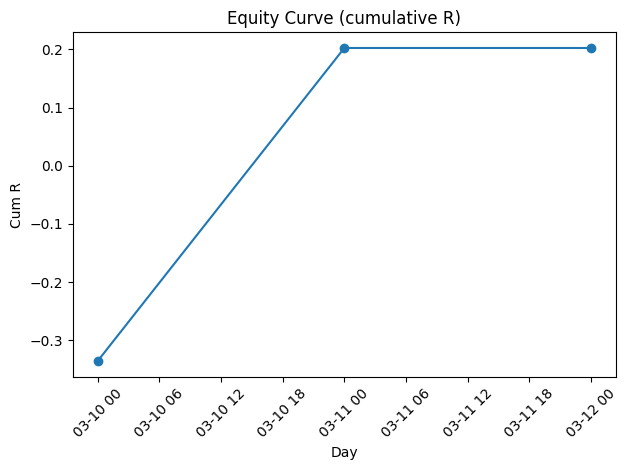

,day,day_R,cum_R
0,2025-03-10,-0.335923,-0.335923
1,2025-03-11,0.538479,0.202555
2,2025-03-12,0.000000,0.202555


,days_tested,trades,netR_total,avg_R_per_trade,max_drawdown_R
0,3,3,0.202555,0.067518,0.0


In [6]:
# === EQUITY CURVE (R) FOR MULTI-DAY RUN ======================================
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from IPython.display import display

# helper: inclusive date range
def date_range(start, end):
    s = date.fromisoformat(start); e = date.fromisoformat(end)
    return [(s + timedelta(days=i)).isoformat() for i in range((e - s).days + 1)]

# 1) choose days (edit these)
days = date_range("2025-03-01", "2025-03-31")

# 2) run multi if we don't already have results in this session
if "multi_trades" not in globals() or multi_trades.empty:
    multi_trades = fib_smoke_multi(days)

if multi_trades.empty:
    print("No trades to plot."); 
else:
    # 3) aggregate to daily and build equity curve in R
    # ensure 'day' is date-like
    dd = multi_trades.copy()
    dd["day"] = pd.to_datetime(dd["day"]).dt.date
    daily = dd.groupby("day", as_index=False)["pnl_R"].sum().rename(columns={"pnl_R":"day_R"})
    daily["cum_R"] = daily["day_R"].cumsum()

    # 4) plot equity curve
    plt.figure()                        # single plot; no specific colors/styles
    plt.plot(daily["day"], daily["cum_R"], marker="o")
    plt.title("Equity Curve (cumulative R)")
    plt.xlabel("Day")
    plt.ylabel("Cum R")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5) quick summary table
    summary = pd.DataFrame({
        "days_tested": [len(daily)],
        "trades": [len(multi_trades)],
        "netR_total": [multi_trades["pnl_R"].sum()],
        "avg_R_per_trade": [multi_trades["pnl_R"].mean()],
        "max_drawdown_R": [(multi_trades["pnl_R"].cumsum() - multi_trades["pnl_R"].cumsum().cummax()).min()]
    })
    display(daily.tail(5))   # last few daily rows
    display(summary)


In [7]:
# === Parameters ===============================================================
# 1) Add your dates here (train set). Use at least 10–20 for stability.
days = [
    '2025-03-10','2025-03-11','2025-03-12'
]

# 2) Parameter grid to test
param_grid = dict(
    ema_fast=[8,9,12],
    ema_slow=[21,26,34],
    rsi_len=[14],
    rsi_long=[48,50,52],
    rsi_short=[48,50,52],
    atr_len=[14,21],
    atr_mult_stop=[0.25,0.5,0.75,1.0],
    retr_low=[0.50,0.382],
    retr_high=[0.618],
    ext_pref=[('161','127'), ('127','161')]
)

# 3) Session windows: US equities example (optional). Comment out to test full day.
session_windows = ("09:35","11:00","14:00","15:45")

# === Run the grid =============================================================
from IPython.display import display
import os

rows = []
keys, vals = zip(*param_grid.items())
for combo in itertools.product(*vals):
    P = dict(zip(keys, combo))
    if P['ema_fast'] >= P['ema_slow']:
        continue
    all_trades = []
    for d in days:
        tdf = simulate_day_with_params(d, **P, session_filter=session_windows)
        if not tdf.empty:
            all_trades.append(tdf)
    if not all_trades:
        continue
    res = pd.concat(all_trades, ignore_index=True)
    metrics = summarize(res)
    rows.append({**P, **metrics})

results = pd.DataFrame(rows)
if not results.empty:
    results = results.sort_values(['netR','pf'], ascending=[False, False])
print("Top results (by netR then PF):")
display(results.head(20))

out_path = os.getenv('FIB_GRID_OUT', '/mnt/data/fib_grid_results.csv')
os.makedirs(os.path.dirname(out_path), exist_ok=True)
results.to_csv(out_path, index=False)
print(f"Saved full grid to {out_path}")


NameError: name 'itertools' is not defined

In [ ]:

# === Optional: equity curve for best combo ===================================
if 'results' in globals() and not results.empty:
    best = results.iloc[0].to_dict()
    print("Best combo:", best)
    # rebuild trade list for best params to plot equity
    all_trades = []
    for d in days:
        tdf = simulate_day_with_params(
            d,
            ema_fast=int(best['ema_fast']),
            ema_slow=int(best['ema_slow']),
            rsi_len=int(best['rsi_len']),
            rsi_long=int(best['rsi_long']),
            rsi_short=int(best['rsi_short']),
            atr_len=int(best['atr_len']),
            atr_mult_stop=float(best['atr_mult_stop']),
            retr_low=float(best['retr_low']),
            retr_high=float(best['retr_high']),
            ext_pref=tuple(best['ext_pref'].strip('()').replace("'","" ).split(',')) if isinstance(best['ext_pref'], str) else best['ext_pref'],
            session_filter=session_windows
        )
        if not tdf.empty:
            all_trades.append(tdf)
    if all_trades:
        tdf = pd.concat(all_trades, ignore_index=True).sort_values('ts_in')
        eq = tdf['pnl_R'].cumsum().reset_index(drop=True)
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(eq.values)
        plt.title('Equity Curve (R) — Best Params')
        plt.xlabel('Trade #')
        plt.ylabel('Cumulative R')
        plt.show()
